# Import photos

In [300]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

%matplotlib inline

In [301]:
base_dir = 'data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training infected Cicada pictures
train_1_dir = os.path.join(train_dir, '1')

# Directory with our training normal Cicada pictures
train_0_dir = os.path.join(train_dir, '0')

# Directory with our validation infected Cicada pictures
validation_1_dir = os.path.join(validation_dir, '1')

# Directory with our validation normal Cicada pictures
validation_0_dir = os.path.join(validation_dir, '0')

# Directory with our test infected Cicada pictures
test_1_dir = os.path.join(test_dir, '1')

# Directory with our test normal Cicada pictures
test_0_dir = os.path.join(test_dir, '0')

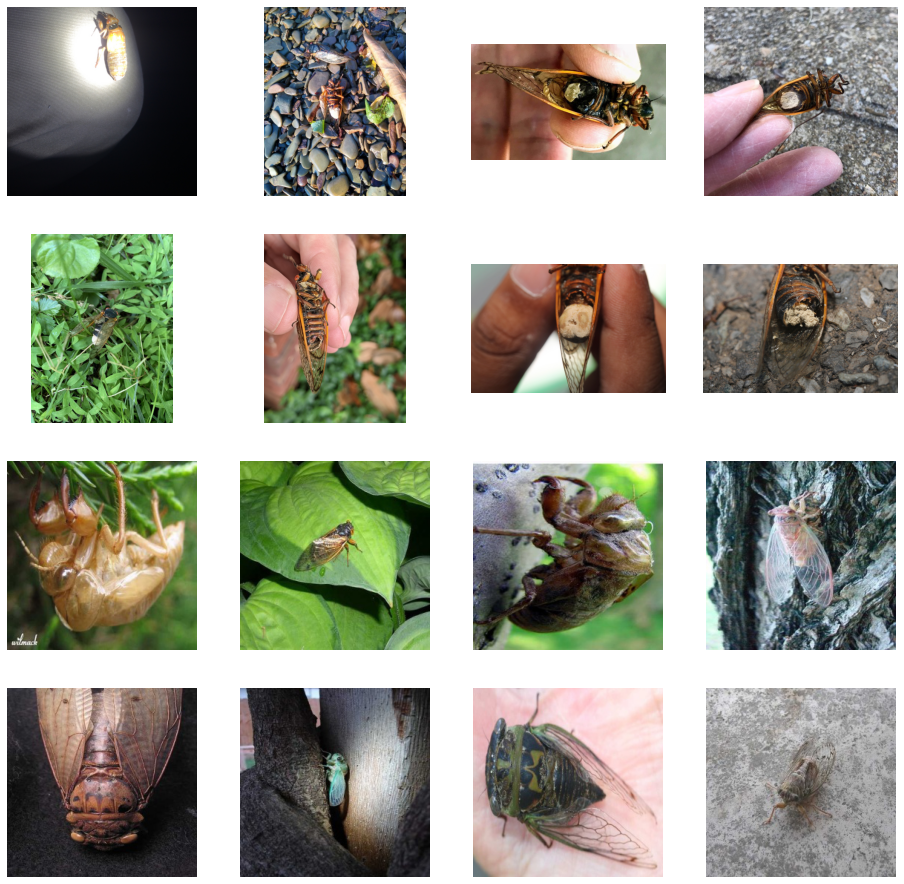

In [302]:
#Set up matplotlib fig, and size it to fit 4x4 pics

import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_1_fnames = os.listdir( train_1_dir )
train_0_fnames = os.listdir( train_0_dir )


next_1_pix = [os.path.join(train_1_dir, fname) 
                for fname in train_1_fnames[ pic_index-8:pic_index] 
               ]

next_0_pix = [os.path.join(train_0_dir, fname) 
                for fname in train_0_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_1_pix+next_0_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Inceptionv2 model

In [232]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [233]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))

Found 1000 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [234]:
test_generator = test_datagen.flow_from_directory(test_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))

Found 540 images belonging to 2 classes.


In [235]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [236]:
for layer in base_model.layers:
    layer.trainable = False

In [238]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [239]:
# ORIGINAL inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)
inc_history = model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=5)

Epoch 1/5
50/50 [==============================] - 27s 487ms/step - loss: 2.0680 - acc: 0.7290 - val_loss: 0.9926 - val_acc: 0.7312
Epoch 2/5
50/50 [==============================] - 24s 490ms/step - loss: 0.6739 - acc: 0.8150 - val_loss: 0.5266 - val_acc: 0.8136
Epoch 3/5
50/50 [==============================] - 27s 540ms/step - loss: 0.6674 - acc: 0.7980 - val_loss: 0.4886 - val_acc: 0.8281
Epoch 4/5
50/50 [==============================] - 24s 477ms/step - loss: 0.5382 - acc: 0.8350 - val_loss: 1.4299 - val_acc: 0.6562
Epoch 5/5
50/50 [==============================] - 24s 481ms/step - loss: 0.4673 - acc: 0.8490 - val_loss: 0.4766 - val_acc: 0.8208


In [266]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

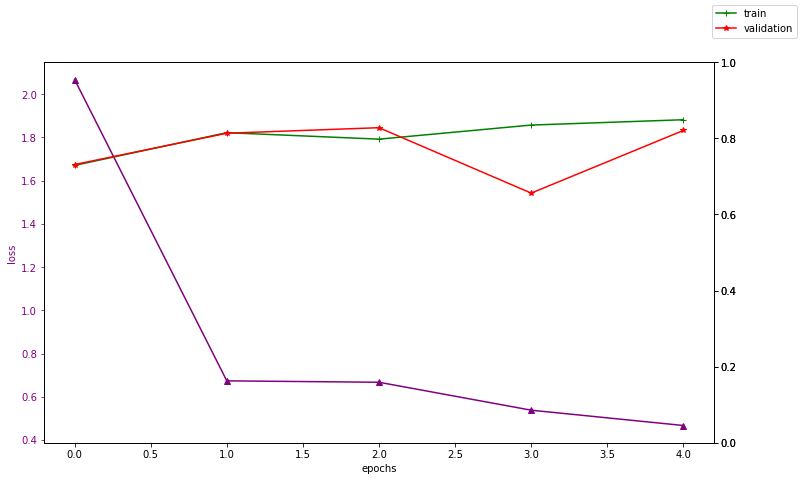

In [240]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(inc_history.epoch, inc_history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(inc_history.epoch, inc_history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(inc_history.epoch, inc_history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)


fig.legend();

In [241]:
inc_history = model.fit(test_generator,verbose=1, epochs=5)

Epoch 1/5
27/27 [==============================] - 9s 317ms/step - loss: 0.2327 - acc: 0.9481
Epoch 2/5
27/27 [==============================] - 9s 325ms/step - loss: 0.1582 - acc: 0.9500
Epoch 3/5
27/27 [==============================] - 10s 365ms/step - loss: 0.1036 - acc: 0.9833
Epoch 4/5
27/27 [==============================] - 9s 339ms/step - loss: 0.0677 - acc: 0.9852
Epoch 5/5
27/27 [==============================] - 9s 341ms/step - loss: 0.0678 - acc: 0.9796


In [166]:
inc_history

In [242]:
#1.Predict classes
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = inc_history.model.predict(test_generator)

# Get most likely class
predicted_classes = [1 * (x[0]>=0.5) for x in predictions]

# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

# 3. Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix,classification_report

print(class_labels)

print(confusion_matrix(test_generator.classes, predicted_classes))

report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

['0', '1']
[[464  32]
 [ 40   4]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       496
           1       0.11      0.09      0.10        44

    accuracy                           0.87       540
   macro avg       0.52      0.51      0.51       540
weighted avg       0.85      0.87      0.86       540

